In [3]:
import sys
import torch

sys.path.append("/workspace/kbqa/")  # go to parent dir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Configuration

In the cell below, you can configure what type of training. For instance, you can choose what type of sequence to train catboost on (both, gap, or g2t); or what kind of dataset (either xl or large). The following options are valid:

* `finetune`: to whether do gridsearch on catboost, or just use default params
* `sequence_type`: choices=[determ, gap, or g2t] 
* `ds_type`: either T5-large-ssm or T5-xl-ssm. The graph features dataset (`features_ds_path`) and the seq2seq outputs dataset (`test_csv_path`) will be depended on the specified model from this argument.
* model_weights: None or the provided model weight, if None, train from scratch
* `save_path`: model weights, reranking results and features importance will be saved in this folder


In [4]:
from pathlib import Path

# None if training from scratch, else eveuating
model_weights = (
   None #"/workspace/storage/misc/features_reranking/no_cherries_fixed_train_g2t_xl/best_model"
)
with_tdidf = False
num_iters = 100000
sequence_type = "gap"
ds_type = "large"
test_csv_path = f"hle2000/Mintaka_T5_{ds_type}_ssm_outputs"
features_ds_path = f"s-nlp/Mintaka_Graph_Features_T5-{ds_type}-ssm"

finetune = False if model_weights else False
save_path = f"/workspace/storage/misc/features_reranking/no_cherries_fixed_train_{sequence_type}_{ds_type}/"
cache_path = "/workspace/storage/misc/huggingface"
if not model_weights:
    Path(save_path).mkdir(parents=True, exist_ok=True)

In [6]:
import numpy as np


def arr_to_str(arr):
    arr = list(arr)
    return ",".join(str(a) for a in arr)


def str_to_arr(str):
    arr = str.split(",")
    arr = [float(a) for a in arr]
    return np.array(arr)

### Reading and Processing the Data

In [7]:
from datasets import load_dataset

graph_features_ds = load_dataset(features_ds_path, cache_dir=cache_path)
processed_train_df = graph_features_ds["train"].to_pandas()
processed_val_df = graph_features_ds["validation"].to_pandas()
processed_test_df = graph_features_ds["test"].to_pandas()

Found cached dataset parquet (/workspace/storage/misc/huggingface/s-nlp___parquet/s-nlp--Mintaka_Graph_Features_T5-xl-ssm-b86a615720d5466b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

##### Processing Numeric Features

In [8]:
def get_numeric_cols(df):
    """return all cols with numeric features"""
    cols_numeric = []
    for k, v in df.dtypes.to_dict().items():
        if (v is np.dtype("int64") or v is np.dtype("float64")) and k != "correct":
            cols_numeric.append(k)

    return cols_numeric

In [9]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()


def apply_col_scale(df, col, scale_type):
    """apply min max scaling"""
    if scale_type == 'train':
        df[col] = min_max_scaler.fit_transform(df[col])
    else:
        df[col] = min_max_scaler.transform(df[col])
    return df

# get the numerica cols in train and test to scale
train_numeric_cols = get_numeric_cols(processed_train_df)
val_numeric_cols = get_numeric_cols(processed_val_df)
test_numeric_cols = get_numeric_cols(processed_test_df)

processed_train_df = apply_col_scale(processed_train_df, train_numeric_cols, 'train')
processed_val_df = apply_col_scale(processed_val_df, val_numeric_cols, 'val')
processed_test_df = apply_col_scale(processed_test_df, test_numeric_cols, 'test')

##### Processing Text and Embedding Features

In [10]:
def filter_df_sequence(dataframe, seq_type):
    """filter df base on the sequence type,
    return filtered df & textual + embedding features"""
    textual_feat = ["determ_sequence", "g2t_sequence", "gap_sequence"]
    
    if seq_type == "g2t":
        rm_lst = ["determ_sequence", "gap_sequence"]
    elif seq_type == "determ":
        rm_lst = ["g2t_sequence", "gap_sequence"]
    elif seq_type == "gap":
        rm_lst = ["determ_sequence", "g2t_sequence"]
    drop_text_cols = [item for item in textual_feat if item in rm_lst]
    drop_em_cols = [f"{feat}_embedding" for feat in drop_text_cols]
    dataframe = dataframe.drop(drop_text_cols + drop_em_cols, axis=1)
    textual_feat = [f"{seq_type}_sequence"]
    emb_feat = [f"{seq_type}_sequence_embedding"]
    
    return dataframe, textual_feat, emb_feat

In [11]:
text_features = ["question_answer"]
emb_features = ["question_answer_embedding"]
processed_train_df, textual_feats, embd_feats = filter_df_sequence(
    processed_train_df, sequence_type
)
processed_val_df, _, _ = filter_df_sequence(processed_val_df, sequence_type)
processed_test_df, _, _ = filter_df_sequence(processed_test_df, sequence_type)
text_features += textual_feats
emb_features += embd_feats

In [12]:
# make sure text features are str dtype
def process_text_features(df, text_features):
    for text_feat in text_features:
        df[text_feat] = df[text_feat].astype("string")
    return df


processed_train_df = process_text_features(processed_train_df, text_features)
processed_val_df = process_text_features(processed_val_df, text_features)
processed_test_df = process_text_features(processed_test_df, text_features)

processed_train_df = processed_train_df.dropna()
processed_val_df = processed_val_df.dropna()
processed_test_df = processed_test_df.dropna()

In [14]:
# turn str representation of embeddings back to np array
for e_f in emb_features:
    print(e_f)
    processed_train_df[e_f] = processed_train_df[e_f].apply(str_to_arr)
    processed_val_df[e_f] = processed_val_df[e_f].apply(str_to_arr)
    processed_test_df[e_f] = processed_test_df[e_f].apply(str_to_arr)

question_answer_embedding
g2t_sequence_embedding


In [15]:
# dropping TDA tfidf
processed_train_df = processed_train_df.drop("tfidf_vector", axis=1)
processed_val_df = processed_val_df.drop("tfidf_vector", axis=1)
processed_test_df = processed_test_df.drop("tfidf_vector", axis=1)

# preparing data for catboost training
drop_cols = ["correct", "question"]
X_train = processed_train_df.drop(drop_cols, axis=1)
y_train = processed_train_df["correct"].tolist()
X_test = processed_val_df.drop(drop_cols, axis=1)
y_test = processed_val_df["correct"].tolist()

In [16]:
import numpy as np


def find_weight(target):
    """find weight for imbalanced classification"""
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)]
    )
    weight = 1.0 / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in target])

    samples_weight = np.double(samples_weight)
    return samples_weight

#### Catboost

In [17]:
from catboost import Pool, CatBoostRegressor

learn_pool = Pool(
    X_train,
    y_train,
    text_features=text_features,
    feature_names=list(X_train),
    embedding_features=emb_features,
    weight=find_weight(y_train),
)

test_pool = Pool(
    X_test,
    y_test,
    text_features=text_features,
    feature_names=list(X_test),
    embedding_features=emb_features,
)

#### Grid search

In [18]:
if finetune:
    print("finetuning")
    params = {
        "learning_rate": [0.03, 0.1],
        "depth": [4, 6, 10],
        "l2_leaf_reg": [5, 7, 9, 11],
    }
    model = CatBoostRegressor()
    grid_search_result = model.grid_search(params, learn_pool)

    lr = grid_search_result["params"]["learning_rate"]
    depth = grid_search_result["params"]["depth"]
    leaf = grid_search_result["params"]["l2_leaf_reg"]
else:
    lr = 0.1
    depth = 6
    leaf = 9

#### Fitting best params

In [19]:
if model_weights:  # eval
    print("loading model")
    model = CatBoostRegressor()  # parameters not required.
    model.load_model(model_weights)
else:  # train from scratch
    print("training from scratch")
    model = CatBoostRegressor(
        iterations=num_iters,
        learning_rate=lr,
        depth=depth,
        l2_leaf_reg=leaf,
        # task_type="GPU",
        early_stopping_rounds=1000,
        eval_metric="RMSE",
    )

    model.fit(learn_pool, eval_set=test_pool, verbose=200)
    model.save_model(Path(save_path) / "best_model")
    print(f"model saved at {save_path}")

loading model


#### Reranking

In [20]:
from datasets import load_dataset, DatasetDict, Dataset
seq2seq_outputs = load_dataset(
    test_csv_path, verification_mode="no_checks", cache_dir=cache_path
)
train_seq2seq = seq2seq_outputs['train'].to_pandas()
test_seq2seq = seq2seq_outputs['test'].to_pandas()
val_seq2seq = seq2seq_outputs['validation'].to_pandas()

Found cached dataset parquet (/workspace/storage/misc/huggingface/hle2000___parquet/hle2000--Mintaka_T5_xl_ssm_outputs-059583fb07b6dc35/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
from tqdm import tqdm
def rerank(test_df, seq2seq_res, black_list):
    final_acc, top200_total, top1_total, seq2seq_correct = 0, 0, 0, 0
    exclude = 0

    for idx, group in tqdm(seq2seq_res.iterrows()):
        curr_question_df = test_df[
            test_df["question"] == group["question"]
        ]
        if group['question'] in black_list:
            exclude += 1
            continue
        curr_question_df = curr_question_df.drop("question", axis=1)
        
        if (
            len(curr_question_df) == 0
        ):  # we don't have subgraph for this question, take answer from seq2seq
            if group["answer_0"] == group["target"]:
                seq2seq_correct += 1
            else:  # check if answer exist in 200 beams for question with no subgraphs
                all_beams = group.tolist()[2:-1]  # all 200 beams
                all_beams = set(all_beams)
                top200_total += 1 if group["target"] in all_beams else 0

        else:  # we have subgraph for this question
            all_beams = group.tolist()[2:-1]  # all 200 beams
            all_beams = set(all_beams)

            if group["target"] not in all_beams:  # no correct answer in beam
                continue

            # correct answer exist in beam
            top1_total += 1 if group["answer_0"] == group["target"] else 0
            top200_total += 1

            is_corrects = curr_question_df["correct"].astype(bool).tolist()
            curr_rows = curr_question_df.drop(["correct"], axis=1)

            preds = model.predict(curr_rows)
            max_idx = preds.argmax()

            if is_corrects[max_idx] is True:
                final_acc += 1

    # final reranking, top1 and top200 result
    reranking_res = (final_acc + seq2seq_correct) / (len(seq2seq_res) - exclude)
    top200 = (top200_total + seq2seq_correct) / (len(seq2seq_res) - exclude)
    top1 = (top1_total + seq2seq_correct) / (len(seq2seq_res) - exclude)
    return reranking_res, top1, top200

##### None filtered re-ranking (4000 questions)

In [23]:
val_reranking_res, val_top1, val_top200 = rerank(processed_val_df, val_seq2seq, [])
test_reranking_res, test_top1, test_top200 = rerank(processed_test_df, test_seq2seq, [])
with open(Path(save_path) / "reranking_results", "w+") as f:
    f.write(f"Val: reranked@1: {val_reranking_res}, original@1: {val_top1}, @200: {val_top200}\n")
    f.write(f"Test: reranked@1: {test_reranking_res}, original@1: {test_top1}, @200: {test_top200}\n")

print(f"Val: reranked@1: {val_reranking_res}, original@1: {val_top1}, @200: {val_top200}")
print(f"Test: reranked@1: {test_reranking_res}, original@1: {test_top1}, @200: {test_top200}")

2000it [00:16, 124.47it/s]
4000it [00:27, 146.64it/s]

Val: reranked@1: 0.374, original@1: 0.3275, @200: 0.686
Test: reranked@1: 0.3275, original@1: 0.31725, @200: 0.69025


##### filtered re-ranking (3200 questions questions)

In [24]:
def get_black_list(ds):
    exclude_ds = ds[(ds['complexityType'] == 'yesno') | (ds['complexityType'] == 'count')]
    exclude_ques = exclude_ds['question'].tolist()
    return exclude_ques

mintaka = load_dataset('AmazonScience/mintaka', cache_dir="/workspace/storage/misc/huggingface")
exclude_ques_val = get_black_list(mintaka['validation'].to_pandas())
exclude_ques_test = get_black_list(mintaka['test'].to_pandas())

No config specified, defaulting to: mintaka/en
Found cached dataset mintaka (/workspace/storage/misc/huggingface/AmazonScience___mintaka/en/1.0.0/bb35d95f07aed78fa590601245009c5f585efe909dbd4a8f2a4025ccf65bb11d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [26]:
val_reranking_res, val_top1, val_top200 = rerank(processed_val_df, val_seq2seq, exclude_ques_val)
test_reranking_res, test_top1, test_top200 = rerank(processed_test_df, test_seq2seq, exclude_ques_test)
with open(Path(save_path) / "filtered_reranking_results", "w+") as f:
    f.write(f"Val: reranked@1: {val_reranking_res}, original@1: {val_top1}, @200: {val_top200}\n")
    f.write(f"Test: reranked@1: {test_reranking_res}, original@1: {test_top1}, @200: {test_top200}\n")

print(f"Val: reranked@1: {val_reranking_res}, original@1: {val_top1}, @200: {val_top200}")
print(f"Test: reranked@1: {test_reranking_res}, original@1: {test_top1}, @200: {test_top200}")

2000it [00:12, 159.10it/s]
4000it [00:27, 145.90it/s]

Val: reranked@1: 0.296875, original@1: 0.300625, @200: 0.6125
Test: reranked@1: 0.3009375, original@1: 0.288125, @200: 0.6203125


#### Features Importance

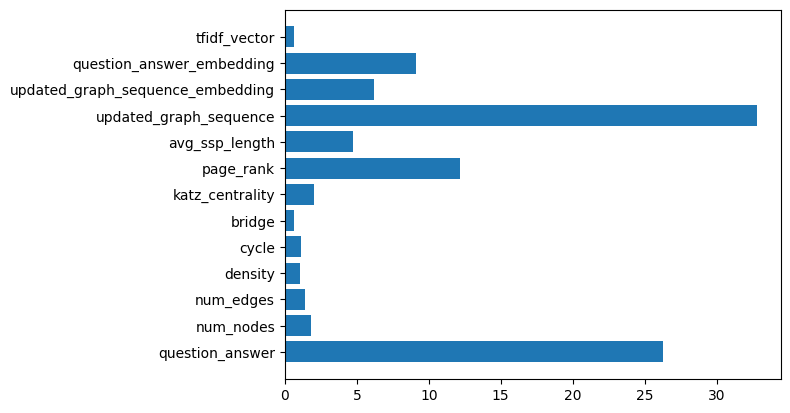

In [31]:
import matplotlib.pyplot as plt

col_names = X_test.columns.tolist()
features_importance = model.get_feature_importance(data=test_pool)

plt.barh(col_names, features_importance)
plt.tight_layout()
plt.savefig(Path(save_path) / "features_importance.png")
plt.show()